# Normal likelihoods and normal-inverse-gamma priors

Today we explore how samples from a prior distribution can be interpreted as instances of the likelihood function. Specifically, we look at how samples from a normal-inverse-gamma (NIG) distribution can be interpreted as normal distributions.

**In short:** Each sample from the NIG distribution is a pair $(x, \sigma^2)$. These values specify the mean and variance of a normal distribution and so we can think of the sample (the pair of values) as an instance of the normal distribution (which will be our likelihood function). More below.

## Normal-inverse-gamma in SciPy

Even though SciPy does have classes defined for the normal distribution (`scipy.stats.norm`) and the inverse-gamma distribution (`scipy.stats.invgamma`), it does not have one defined for the normal-inverse-gamma distribution. To help you, the functions below implement the probability density function and a sampler for the normal-inverse-gamma distribution.

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
'''
Function definitions for the normal-inverse-gamma distribution. The parameters
of the distribution, namely mu (μ), either lambda (λ) or nu (ν), alpha (α),
beta (β), are used as defined here:

  https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution

Note that we use the symbol nu (ν) rather than lambda (λ) for the third
parameter. This is to match the notation used in the conjugate priors table on
Wikipedia:

  https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions
'''

def norminvgamma_pdf(x, sigma2, mu, nu, alpha, beta):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    x (mean) and sigma2 (variance).
    '''
    return (
        sts.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2 / nu)) *
        sts.invgamma.pdf(sigma2, a=alpha, scale=beta))

def norminvgamma_rvs(mu, nu, alpha, beta, size=1):
    '''
    Generate n samples from the normal-inverse-gamma distribution. This function
    returns a (size x 2) matrix where each row contains a sample, (x, sigma2).
    '''
    # Sample sigma^2 from the inverse-gamma distribution
    sigma2 = sts.invgamma.rvs(a=alpha, scale=beta, size=size)
    # Sample x from the normal distribution
    x = sts.norm.rvs(loc=mu, scale=np.sqrt(sigma2 / nu), size=size)
    return np.vstack((x, sigma2)).transpose()

## Task 1

1. Generate 10 samples from the normal-inverse-gamma (NIG) distribution with parameters as
   provided below.
   
   Each sample corresponds to the mean and variance of a normal
   distribution.
   
   With these NIG parameters, the prior 95% confidence interval for
   the mean is about [-10, 10] and for the variance [0.1, 10].
   
   In practice you would
   work the other way around: use confidence intervals (or other information) to determine values for the
   prior hyperparameters.


2. Plot the 10 normal distributions corresponding to your 10 samples. To see the functions
   clearly, plot your graphs on the domain [-15, 15].
   
   You should see that the 10 samples
   (normal distributions) are all quite different. This means the prior is quite broad
   (uncertain) over the mean and variance.

In [4]:
# Normal-inverse-gamma prior hyperparameters
mu_0 = 0        # The prior mean is centered around 0.
nu_0 = 0.054    # The smaller ν₀ is, the more uncertain we are about the prior mean.
alpha_0 = 1.12  # α₀ and β₀ control the marginal prior over the variance.
beta_0 = 0.4

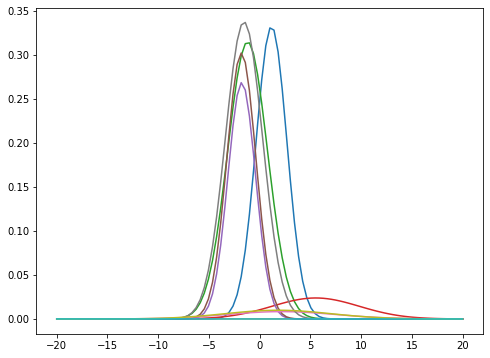

In [10]:
samples = norminvgamma_rvs(mu_0, nu_0, alpha_0, beta_0, 10)  # YOU HAVE TO COMPLETE THIS
# YOU HAVE TO PLOT THE NORMAL PDF CORRESPONDING TO EACH SAMPLE ABOVE
x_array = np.linspace(-20,20,100)
plt.figure(figsize=(8,6))
for mu, sigma in samples:
    pdf = norminvgamma_pdf(x_array, sigma, mu, nu_0, alpha_0, beta_0)
    plt.plot(x_array, pdf)

## Task 2

Generate 1,000,000 samples from the normal-inverse-gamma prior above and calculate
approximate 95% confidence intervals over the mean and the variance using the
samples. You can use the `numpy.percentile` function for this.

Your confidence intervals should approximately match the intervals [-10, 10] and [0.1, 10].

In [14]:
samples = norminvgamma_rvs(mu_0, nu_0, alpha_0, beta_0, 1000000)
mean_samples = samples[:, 0]
variance_samples = samples[:, 1]
print("95% confidence interval over the mean: ", [np.percentile(mean_samples, 2.5), np.percentile(mean_samples, 97.5)])
print("95% confidence interval over the variance: ", [np.percentile(variance_samples, 2.5), np.percentile(variance_samples, 97.5)])

95% confidence interval over the mean:  [-9.97880120306627, 10.074083293107574]
95% confidence interval over the variance:  [0.10185973385024165, 10.174785732017062]


## Task 3
Code the equations for calculating the posterior normal-inverse-gamma hyperparameters
from the prior hyperparameters and data.

The equations are found on found [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions) and reproduced below, using $d_i$ for a datum.
Note that $n$ is the number of data, and $\overline{d}$ is the mean of the data.

$$
\begin{align}
  \mu_{\text{post}} &= \frac{\nu_0\mu_0 + n\overline{d}}{\nu_0 + n} \\
  \nu_{\text{post}} &= \nu_0 + n \\
  \alpha_{\text{post}} &= \alpha_0 + \frac{n}{2} \\
  \beta_{\text{post}} &=
     \beta_0 +
     \frac{1}{2}\sum_{i=1}^n (d_i-\overline{d})^2 +
     \frac{n\nu_0}{\nu_0+n}\frac{(\overline{d}-\mu_0)^2}{2}
\end{align}
$$

Once you have the update equations implemented, Bayesian inference is done!

 * The likelihood function is the normal distribution with unknown mean and variance.
 * The posterior distribution is of the same type as the prior – normal-inverse-gamma.
 * The posterior parameters below give you the exact posterior normal-inverse-gamma distribution.
 * No approximation or numerical integration is needed.

In [15]:
# Normal-inverse-gamma prior hyperparameters
mu_0 = 0        # The prior mean is centered around 0.
nu_0 = 0.054    # The smaller ν₀ is, the more uncertain we are about the prior mean.
alpha_0 = 1.12  # α₀ and β₀ control the marginal prior over the variance.
beta_0 = 0.4

data = np.array([1, 2, 3, 4])  # In class you will get a larger data set.
                               # This is just to get you started.
mu_post = (nu_0*mu_0 + len(data)*np.mean(data))/(nu_0+len(data)) 
nu_post = nu_0 + len(data)
alpha_post = alpha_0 + len(data)/2
beta_post = beta_0 + 1/2*np.sum([(datum-np.mean(data))**2 for datum in data]) + len(data)*nu_0/(nu_0+len(data))*(np.mean(data)-mu_0)**2/2

## Task 4 (optional)

You are told that the prior information we used above is incorrect. Actually, the prior 95%
confidence interval on the mean should be [-15, 15] and on the variance [0.5, 2]. So, the prior
over the mean is less certain (broader) than we had before, but the prior over the variance is
more certain (narrower).

Determine prior hyperparameters for the normal-inverse-gamma distribution that match the
prior information above.